In [1]:
import torch as T
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = T.device("cpu")


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1]
])

train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Reduce dataset size for faster training (optional)
train_ds = T.utils.data.Subset(train_ds, list(range(1000)))
test_ds = T.utils.data.Subset(test_ds, list(range(100)))

# Filter to keep only images with label 0 or 1
def filter_01(dataset):
    idxs = [i for i in range(len(dataset)) if dataset[i][1] in [0, 1]]
    return T.utils.data.Subset(dataset, idxs)

train_ds = filter_01(train_ds)
test_ds = filter_01(test_ds)

train_ldr = T.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True)


In [3]:
class Net(T.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = T.nn.Conv2d(1, 32, 5)
        self.conv2 = T.nn.Conv2d(32, 64, 5)
        self.pool1 = T.nn.MaxPool2d(2, stride=2)
        self.pool2 = T.nn.MaxPool2d(2, stride=2)
        self.drop1 = T.nn.Dropout(0.25)
        self.drop2 = T.nn.Dropout(0.50)
        self.fc1 = T.nn.Linear(1024, 512)
        self.fc2 = T.nn.Linear(512, 256)
        self.fc3 = T.nn.Linear(256, 2)  
    def forward(self, x):
        z = T.relu(self.conv1(x))
        z = self.pool1(z)
        z = self.drop1(z)
        z = T.relu(self.conv2(z))
        z = self.pool2(z)
        z = z.view(-1, 1024)
        z = T.relu(self.fc1(z))
        z = self.drop2(z)
        z = T.relu(self.fc2(z))
        z = self.fc3(z)
        return z


In [4]:
def accuracy(model, ds):
    ldr = T.utils.data.DataLoader(ds, batch_size=len(ds), shuffle=False)
    n_correct = 0
    for data in ldr:
        (pixels, labels) = data
        with T.no_grad():
            oupts = model(pixels)
        (_, predicteds) = T.max(oupts, 1)
        n_correct += (predicteds == labels).sum().item()
    return n_correct / len(ds)


In [5]:
net = Net().to(device)
loss_func = T.nn.CrossEntropyLoss()
optimizer = T.optim.SGD(net.parameters(), lr=0.005)
max_epochs = 50

net.train()
for epoch in range(max_epochs):
    ep_loss = 0
    for (X, y) in train_ldr:
        optimizer.zero_grad()
        oupt = net(X)
        loss_val = loss_func(oupt, y)
        ep_loss += loss_val.item()
        loss_val.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {ep_loss:.4f}")


Epoch 0 | Loss: 15.2274
Epoch 5 | Loss: 13.8408
Epoch 10 | Loss: 8.1198
Epoch 15 | Loss: 1.6891
Epoch 20 | Loss: 0.8020
Epoch 25 | Loss: 0.5084
Epoch 30 | Loss: 0.3332
Epoch 35 | Loss: 0.2720
Epoch 40 | Loss: 0.1813
Epoch 45 | Loss: 0.1413


In [6]:
net.eval()
train_acc = accuracy(net, train_ds)
print(f"Accuracy on training set: {train_acc:.4f}")

test_acc = accuracy(net, test_ds)
print(f"Accuracy on test set: {test_acc:.4f}")


Accuracy on training set: 1.0000
Accuracy on test set: 1.0000


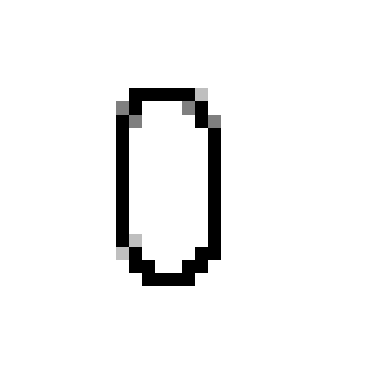

Predicted class: 'zero'


In [7]:

from PIL import Image  # type: ignore
from PIL import ImageOps

img = Image.open("drawing_1.png").convert("L").resize((28, 28))
img = ImageOps.invert(img)  # Invert the image colors
x = np.array(img, dtype=np.float32) / 255.0

plt.imshow(x, cmap='gray')
plt.axis('off')
plt.show()

x = x.reshape(1, 1, 28, 28)
x = T.tensor(x, dtype=T.float32).to(device)
with T.no_grad():
    oupt = net(x)
am = T.argmax(oupt)
digits = ['zero', 'one']
print(f"Predicted class: '{digits[am]}'")


In [8]:
T.save(net.state_dict(), "./mnist_model.pt")
print("Model saved.")


Model saved.


Epoch 0 | Loss: 15.1473
Epoch 5 | Loss: 14.5626
Epoch 10 | Loss: 12.9259
Epoch 15 | Loss: 6.8039
Epoch 20 | Loss: 1.5780
Epoch 25 | Loss: 0.8040
Epoch 30 | Loss: 0.3480
Epoch 35 | Loss: 0.2648
Epoch 40 | Loss: 0.2840
Epoch 45 | Loss: 0.1899


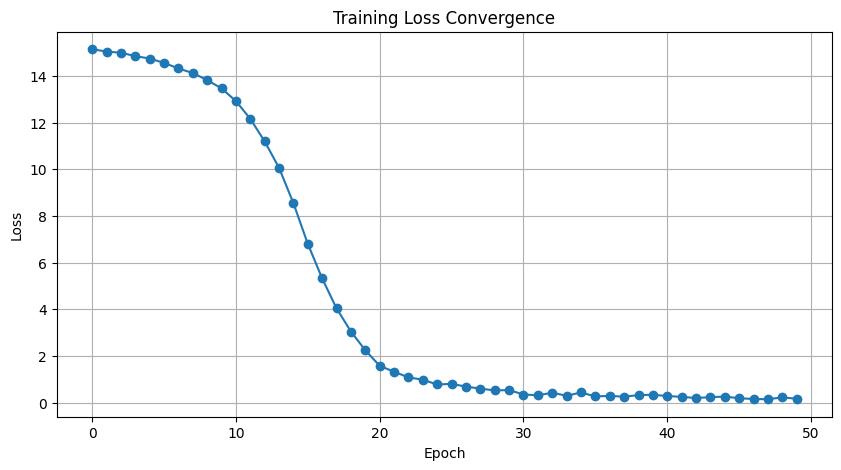

In [9]:
# This cell retrains the model, records loss values and plots the loss convergence

loss_history = []
net = Net().to(device)
loss_func = T.nn.CrossEntropyLoss()
optimizer = T.optim.SGD(net.parameters(), lr=0.005)
max_epochs = 50

net.train()
for epoch in range(max_epochs):
    ep_loss = 0
    for (X, y) in train_ldr:
        optimizer.zero_grad()
        output = net(X)
        loss_val = loss_func(output, y)
        ep_loss += loss_val.item()
        loss_val.backward()
        optimizer.step()
    loss_history.append(ep_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {ep_loss:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(max_epochs), loss_history, marker='o')
plt.title('Training Loss Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()